In [1]:
###
# Plot P and S wave epicentral distance vs arrival time for M5.0+ earthquakes from 1981-present
#
# Author : Aparna Bhaskaran (aparnab at caltech.edu)
###

import pandas as pd
import boto3
from pathlib import Path

In [24]:
#S3 bucket, SCEDC public data set
scedc_bucket = "scedc-pds" 
#prefix for index of the catalog in csv format
catalog_prefix = "earthquake_catalogs/index/csv/" 
#prefix for phases
phase_prefix = "event_phases"

In [25]:
s3 = boto3.resource('s3')
bucket = s3.Bucket(scedc_bucket)


/Users/aparnabhaskaran/anaconda3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [26]:
# retrieve the list of index files at s3://scedc-pds/earthquake_catalogs/index/csv/
key = catalog_prefix 
index_list = list(bucket.objects.filter(Prefix=key))

In [18]:
# from the list of indexes, only download the indexes for 1981-present
for obj in index_list:
    index_file = os.path.basename(obj.key)
    if int(index_file.split('_')[0]) >= 1981:
        #delete the csv if it exists
        Path(index_file).unlink()
        #download
        bucket.download_file(obj.key, index_file)
        

In [19]:
#read the csv files and create a catalog
catalog = pd.DataFrame()
for csv in sorted(Path('.').glob("*.csv")):
    if catalog.empty:
        catalog = pd.read_csv(csv)
    else:
        catalog = pd.concat([catalog, pd.read_csv(csv)])
        

In [20]:
#query the catalog for local events (gtype = 'l') with magnitude >= 5.0 (MAG >= 5.0)
temp = catalog.loc[(catalog['MAG'] >= 5.0) & (catalog['GT'] == 'l') , ["PREFIX","PHASE_FILENAME","EVID"]]

# collect only those records that have a non-null PHASE_FILENAME entry in the catalog
phases = temp[temp["PHASE_FILENAME"].notna()]


In [21]:
# download the phase files; s3://scedc-pds/event_phases/year=YYYY/YYYY_JJJ/evid.phase
for i in phases.itertuples():
    key = phase_prefix + "/" + i.PREFIX + i.PHASE_FILENAME
    # delete the PHASE_FILENAME if it exists
    Path(i.PHASE_FILENAME).unlink()
    bucket.download_file(key, i.PHASE_FILENAME)
    

In [22]:
# datastructures to store tuples of (distance, arrival time) for P and S waves
p = []
s = []

for phase_file in sorted(Path('.').glob("*.phase")):
    with open(phase_file,'r') as fp:
        alllines = fp.readlines()
    for line in alllines[1:]:
        net, sta, seedchan, location, lat, lon, elev, phase, first_motion, sig_quality, pick_quality, distance, time = [item for item in line.strip().split(' ') if item != '']
        if phase.lower() == 'p':
            p.append((float(distance), float(time)))
        if phase.lower() == 's':
            s.append((float(distance), float(time)))
            
# sort in ascending order by distance            
p.sort()
s.sort()


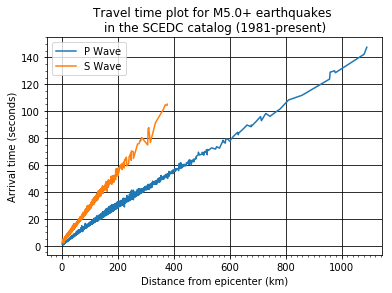

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np
#convert the tuples to numpy arrays for plotting
# p-wave
xp = np.asarray([item[0] for item in p])
yp = np.asarray([item[1] for item in p])

# s-wave
xs = np.asarray([item[0] for item in s])
ys = np.asarray([item[1] for item in s])

# plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(xp, yp, color='tab:blue', label="P Wave")
ax.plot(xs, ys, color='tab:orange', label="S Wave")

# set minor ticks
ax.xaxis.set_minor_locator(MultipleLocator(20)) #km
ax.yaxis.set_minor_locator(MultipleLocator(5))  #seconds
ax.grid(b=True,which='major',color='black', linestyle='-')
ax.set_xlabel("Distance from epicenter (km)")
ax.set_ylabel("Arrival time (seconds)")
ax.set_title("Travel time plot for M5.0+ earthquakes \nin the SCEDC catalog (1981-present)")
plt.legend()
plt.show()
plt.savefig("SCEDC-PvsS-M5-1981-2022.jpg")
